<a href="https://colab.research.google.com/github/lnpanh/CSC14116/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FINAL REPORT

Course: Applied Parallel Programming

18127039 -  Lâm Ngọc Phương Anh

18127046 - Lư Ngọc Liên 

1653098 - Võ Minh Tú


# Enhancing Document Image

## Phát biểu bài toán




### Tổng quan


Enhacing document image là một bước trong công việc xử lý ảnh, là bước nền cơ bản hỗ trợ cho các chức năng nâng cao khác như scan hình ảnh, chuyển đổi ảnh thành text, điều chỉnh lại góc chụp của bức ảnh.

Một vài ứng dụng sử dụng bài toán này là:
- Chức năng scan ảnh trong ứng dụng Note của Iphone
- CamScanner

### Mô tả đầu ra và đầu vào của bài toán






* Đầu vào: một bức ảnh có góc chụp không trực diện với màn hình
* Đầu ra: Bức ảnh có góc chụp trực diện với màn hình (bỏ đi các background dư thừa)

![](https://i.imgur.com/8cfHARR.png)

*cre*: [dropbox.Tech, Jongmin Baek, Aug 16, 2016, Fast document rectification and enhancement](https://dropbox.tech/machine-learning/fast-document-rectification-and-enhancement)

### **Các bước thực hiện**
* Phát hiện biên cạnh
* Lấy viền của đối tượng dựa trên các cạnh đã xác định
* Đưa ảnh tài liệu về đối diện màn hình
* Điều chỉnh độ tương phản, độ sáng của bức ảnh

#### Bước 1: Phát hiện biên cạnh

https://minhng.info/tutorials/xu-ly-anh-opencv-hien-thuc-canny-edge.html

* Phát hiện biên cạnh là bước tìm ra các biên thuộc các đối tượng trong ảnh, nhầm phân tách và biết được hình dạng (shape) các đối tượng đó.
* Có 2 thuật toán nổi tiếng cho bài toán này là Sobel edge detector và Canny edge detector.
* Trong bài toán này nhóm xin chọn sử dụng thuật toán Canny edge detector. Thuật toán gồm 4 bước
    1. Giảm nhiễu: tiến hành làm mờ và giảm nhiễu cho bức ảnh bằng Gaussian ([Công thức của Gaussian Filter](https://docs.opencv.org/2.4/doc/tutorials/imgproc/gausian_median_blur_bilateral_filter/gausian_median_blur_bilateral_filter.html#gaussian-filter))
    2. Tình Gradient và hướng gradient: Sử dụng bộ lọc Sobel X và Sobel Y để lấy ra được đạo hàm theo chiều ngang (Gx) và dọc của bức ảnh (Gy). Từ đó ta sẽ tính được  gradient (độ lớn của sự biến đổi mức sáng ở vị trí pixel tương ứng với ảnh gốc) và hướng của từng pixel trong ảnh theo công thức sau. Trong đó hướng của cạnh được chia thành 4 hướng đại diện: ngang (0 độ), chéo bên phải (45 độ), dọc (90 độ), chéo bên trái (135 độ). 
  $$Edge\_Gradient(G) = \sqrt{G^2_x + G^2_y}$$

  $$Angle (Θ) = tan^{-1} (\frac{G_y}{G_x})$$
  3. Tính non-max suppression: Mục đích lọc bỏ các pixel không phải là cực đại cục bộ. Ta sử dụng 1 filter 3x3 chạy lần lượt qua các pixel của ảnh sau khi đã gradient. Trong các lần chạy, ta xét độ lớn của pixel hiện tại có phải là cực đại so với 2 hàng xóm (dựa trên hướng gradient)  hay không. Nếu là cực đại thì ghi nhận lại pixel đó, ngược lại set độ lớn của pixel đó bằng 0.
  4. Lọc ngưỡng: ở đây ta có 2 giá trị được gọi là maxVal và minVal. Nếu pixel hiện tại có giá trị lớn hơn maxVal thì pixel đó là cạnh, nhỏ hơn minVal thì bị loại bỏ. Còn các pixel nằm giữa maxVal và minVal, ta sẽ xét nó nằm gần với bên nào để quyết định có giữ lại nó hay không. 



* **Có nên tăng tốc giai đoạn xử lý ảnh này không? Tại sao? Và nếu cần tăng tốc thì có thể áp dụng lập trình song song vào không?**
    * **Nên** Thời gian để nhân tích chấp có thể khá lâu nếu bức ảnh có kích thước lớn. 
    * Có thể áp dụng lập trình song song vào ở các bước 1 và bước tính gradient của bước 2 vì các pixel sẽ được tính toán một cách độc lập.

#### Bước 3: Đưa ảnh tài liệu về đối diện màn hình


* Lúc này, ta sẽ lấy các pixel nằm bên trong viền đã được nhận diện ở bước trước đó, thực hiện việc map các điểm ảnh này sang một không gian tọa độ mới (đối diện màn hình).

* Các hướng tiếp cận cho bước có điểm chung là đều được thực hiện bằng cách nhân ma trận trên một hệ tọa độ đồng nhất ([Homogeneous coordinates](https://en.wikipedia.org/wiki/Homogeneous_coordinates)):

    * Sử dụng các **phép xoay ảnh**: Xoay bức ảnh quanh một điểm theo một góc xác định nào đó, vẫn giữ nguyên các tính chất của ảnh (các góc của ảnh vẫn giữ nguyên).
    * Sử dụng phép biến đổi affine: Cần xác định ba điểm trên ảnh gốc và vị trí của chúng trên ảnh kết quả. Biến đổi affine giúp tạo ra nhiều tư thế, biến thể khác nhau của vật thể. Các biến thể này sẽ được bảo toàn tính song song, tỉ lệ khoảng cách của vật thể và các đường thẳng trong ảnh.
    * Sử dụng biến đổi phối cảnh (Perspective transform hoặc Homography transform): Đây là một phép biến đổi đặc biệt khi mà ảnh kết quả không được đảm bảo về góc, độ dài, tính song song so với ảnh gốc ngoại trừ bảo toàn đường thẳng.


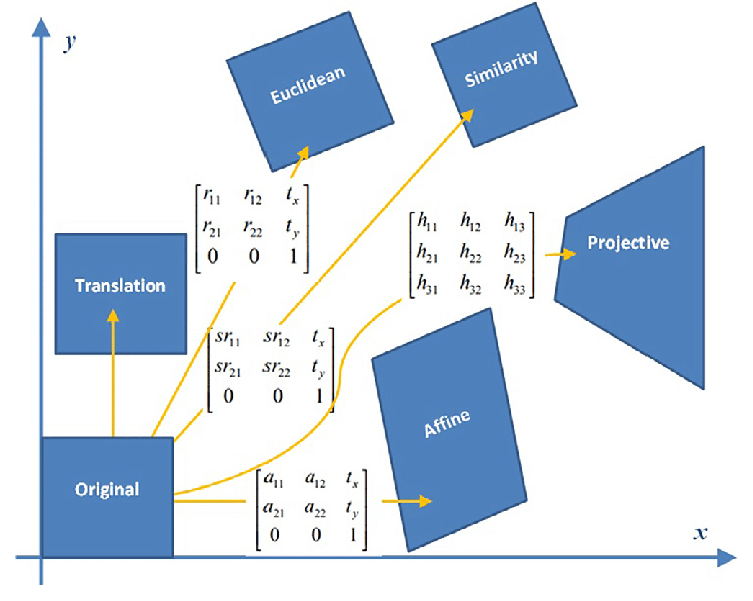

cre: A. Soycan - Metin Soycan (2018), Perspective correction of building facade images for architectural applications. Engineering Science and Technology an International Journal 22(3).

##### **Phép biến đổi Homography**

* Đối với bài toán này, hình dạng của văn bản trong ảnh đầu vào đa dạng và không phải luôn là chữ nhật $→$ **biến đổi phối cảnh** sẽ là giải pháp tốt nhất để có thể đưa văn bản về đối diện màn hình.

* Các bước thực hiện phép biến đổi Homography:
    1. Xác định 4 điểm góc của văn bản trong ảnh đầu vào (source points) và xem nó là 4 đỉnh của ảnh đầu ra (target points).
    2. Dựa trên 4 điểm đã chọn, tính chiều dài và rộng cho ảnh đầu ra $→$ xác định được tọa độ 4 đỉnh trong không gian mới và kích thước của ảnh output.
    3. Khi đã có được source và target points thì ta có thể dễ dàng tính được ma trận biến đổi **H** (3x3).
    4. Thực hiện việc chuyển đổi tọa độ cho từng điểm ảnh bằng công thức sau:
    $$dst(x,y) = src(\frac{H_{0,0}x + H_{0,1}y + H_{0,2}}{H_{2,0}x + H_{2,1}y + H_{2,2}},\frac{H_{1,0}x + H_{1,1}y + H_{1,2}}{H_{2,0}x + H_{2,1}y + H_{2,2}})$$ 


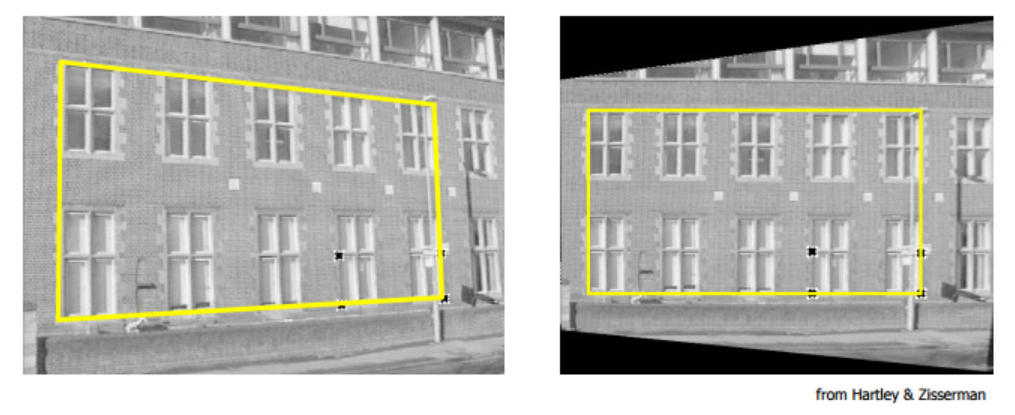

cre: [OpenCV, Basic concepts of the homography explained with code.](https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html)

* **Có nên tăng tốc giai đoạn xử lý ảnh này không? Tại sao? Và nếu cần tăng tốc thì có thể áp dụng lập trình song song vào không?**
    * **Nên** vì có thể thấy tại bước 4 của quá trình này là việc xác định tọa độ mới của từng pixel, điều này có thể sẽ tốn nhiều thời gian khi kích thước bức ảnh lớn.
    * Có thể áp dụng lập trình song song vào **bước 4** vì các pixel sẽ được tính toán một cách độc lập.

#### Bước 4: Điều chỉnh độ tương phản, độ sáng của bức ảnh

* Điều chỉnh độ sáng, độ tương phản của bức ảnh sau khi đã đưa ảnh tài liệu về chính diện màn hình.
* Lúc này ta sẽ sử dụng công thức với 2 quy trình điểm thường được sử dụng là nhân và cộng với một hằng số: 

>>      g (x) = αf (x) + β

* Các tham số α> 0 và β thường được gọi là 
gain and bias parameters, đôi khi các thông số này được cho là để kiểm soát độ tương phản và độ sáng tương ứng.

* Ta có thể coi f(x) là các pixel của ảnh đầu vào và g(x) là các pixel của ảnh đầu ra.

* Chúng ta có thể viết cho dể hình dung:

>>     g (i, j) = α⋅f (i, j) + β

* Trong đó i và j là pixel nằm ở hàng thứ i và cột thứ j.















* **Có nên tăng tốc giai đoạn xử lý ảnh này không? Tại sao? Và nếu cần tăng tốc thì có thể áp dụng lập trình song song vào không?**
    * **Nên** vì có thể thấy tại bước này của quá trình là việc xác định và tiếp cận  từng pixel của 3 kênh màu của ảnh là RGB, điều này có thể sẽ tốn nhiều thời gian khi kích thước bức ảnh lớn.
    * Có thể áp dụng lập trình song song vào **bước 4** vì các pixel sẽ được tính toán một cách độc lập.

## Code

### Nguồn:

Các phần sử dụng hàm của OpenCV :
-  [Canny edge detection](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123?fbclid=IwAR0e9rtoffrqAwTEx9bc8TzpX3y0bgx3UcDRkJR_njyENCY8heaObum6Nks)

- [Find coutours](https://stackoverflow.com/questions/62039403/python-opencv-finding-the-biggest-contour)

- [Homography](https://pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/)

In [49]:
from PIL import Image
from numpy import asarray
from numba import jit
import time
from skimage.filters import threshold_local
import numpy as np
from numba import *
from PIL import *
import requests
from io import BytesIO
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
import math
from google.colab.patches import cv2_imshow
import imutils

import warnings
warnings.filterwarnings('ignore')

In [50]:
img_path = 'img.png'
img = np.asarray(Image.open(img_path))

### Làm xám ảnh

#### Dùng hàm của openCV

CPU times: user 3.91 ms, sys: 1.95 ms, total: 5.87 ms
Wall time: 5.58 ms


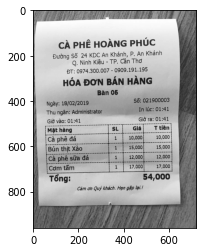

In [51]:
%time gray_cv = cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2GRAY)
plt.imshow(gray_cv, cmap='gray')
plt.show()

#### Dùng hàm của numpy

In [52]:
def convert_RGB_Gray_np(img):
    return np.dot(img[...,:3],[0.2989, 0.5870, 0.1140])

CPU times: user 33.4 ms, sys: 6.15 ms, total: 39.6 ms
Wall time: 42.6 ms


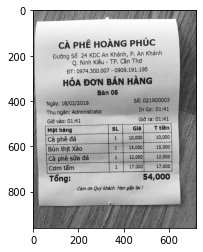

In [53]:
%time gray_np = convert_RGB_Gray_np(img)
plt.imshow(gray_np, cmap='gray')
plt.show()

#### Sử dụng @jit cho python thuần

In [54]:
@jit(cache=True)
def convert_RGB_Gray_py(img):
    gray = np.zeros((img.shape[0],img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            gray[i,j] = img[i,j,0] * 0.2989  + img[i,j,1] * 0.5870 + img[i,j,2] * 0.1140
    return gray

In [55]:
%time gray_py = convert_RGB_Gray_py(img)

CPU times: user 484 ms, sys: 5.75 ms, total: 490 ms
Wall time: 490 ms


CPU times: user 2.58 ms, sys: 0 ns, total: 2.58 ms
Wall time: 2.6 ms


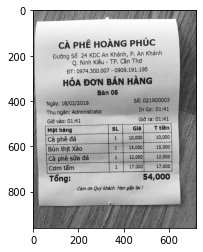

In [56]:
%time gray_py = convert_RGB_Gray_py(img)
plt.imshow(gray_py, cmap='gray')
plt.show()

* So sánh kết quả và thời gian thực thi của ba cách

| Thời gian (ms) | Cách tiếp cận |
|:---:|:---|
||openCV|
|| Numpy|
|| Python loop|
|| Python loop cached (@jit)|

In [57]:
print("openCV vs Numpy: ", np.abs(gray_cv - gray_np).mean())
print("openCV vs Python (@jit): ", np.abs(gray_cv - gray_py).mean())
print("Python (@jit) vs Numpy: ", np.abs(gray_py - gray_np).mean())

openCV vs Numpy:  0.16093175795717682
openCV vs Python (@jit):  0.16093175795717682
Python (@jit) vs Numpy:  0.0


### Phát hiện biên cạnh

#### Dùng hàm của OpenCV

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.7 µs


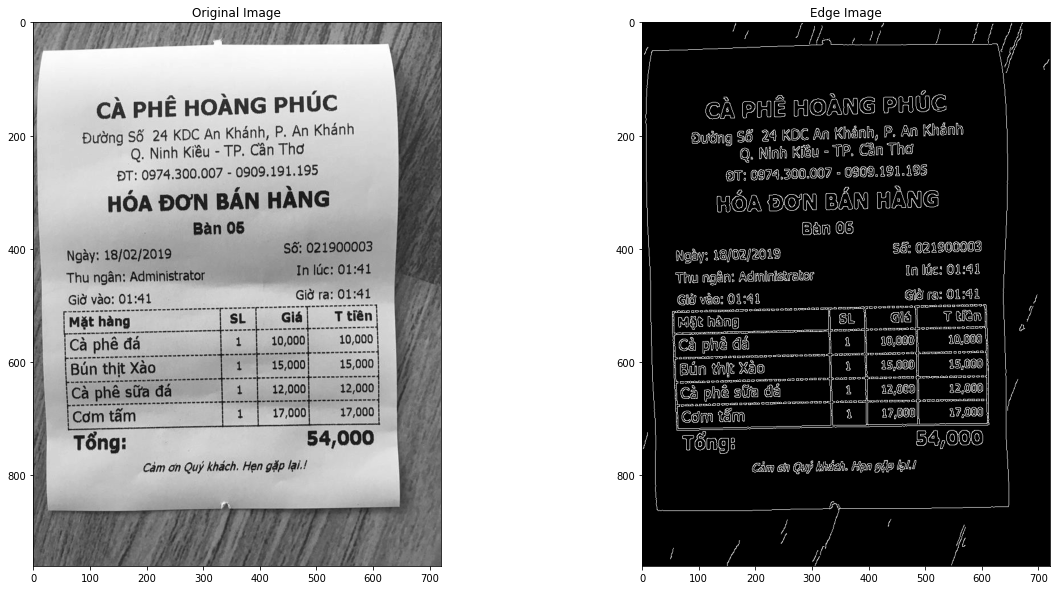

In [58]:
%time 
gaussian = cv2.GaussianBlur(gray_cv,(3,3),cv2.BORDER_DEFAULT)
canny_edge_cv = cv2.Canny(gaussian,100,200)

fig, axis = plt.subplots(1,2, figsize = (20,10));
axis[0].imshow(gray_cv,cmap = 'gray');
axis[0].set_title('Original Image');
axis[1].imshow(canny_edge_cv,cmap = 'gray');
axis[1].set_title('Edge Image');

#### **Giảm nhiễu**

##### Một số hàm khởi tạo

Nguồn: [Hàm gaussian_kernel](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123?fbclid=IwAR0e9rtoffrqAwTEx9bc8TzpX3y0bgx3UcDRkJR_njyENCY8heaObum6Nks)

In [59]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [60]:
gau_kernel_size = 3
gau_kernel = gaussian_kernel(gau_kernel_size)

##### Dùng hàm của openCV

CPU times: user 3.14 ms, sys: 2 µs, total: 3.14 ms
Wall time: 2.98 ms


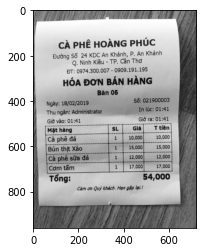

In [61]:
%time gaussianBlur_cv = cv2.GaussianBlur(gray_cv, (gau_kernel_size, gau_kernel_size), cv2.BORDER_DEFAULT)
plt.imshow(gaussianBlur_cv, cmap='gray')
plt.show()

##### Dùng hàm của numpy

In [62]:
def convolutionLayer_np(img, kernel):
    rows_k, cols_k = kernel.shape
    rows, cols = img.shape
    
    return ndimage.filters.convolve(img, kernel, mode='reflect')

CPU times: user 19.2 ms, sys: 0 ns, total: 19.2 ms
Wall time: 26.9 ms


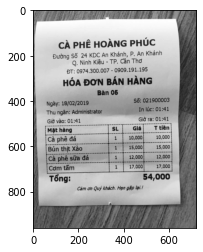

In [63]:
%time gaussianBlur_np = convolutionLayer_np(gray_np, gau_kernel)
plt.imshow(gaussianBlur_np, cmap='gray')
plt.show()

##### Sử dụng @jit cho python thuần

In [64]:
@jit(cache=True)
def convolutionLayer_py(img, kernel):
    img_out = np.zeros(img.shape)
    rows, cols = img.shape
    rows_k, cols_k = kernel.shape
    for r in range(rows):
        for c in range(cols):
            out = 0
            for r_k in range(rows_k):
                for c_k in range(cols_k):
                    in_r = r - rows_k//2 + r_k;
                    in_c = c - cols_k//2 + c_k;
                    in_r = min(max(0, in_r), rows - 1);
                    in_c = min(max(0, in_c), cols - 1);
                    out += kernel[r_k,c_k] * img[in_r,in_c];
            img_out[r,c] = out
    return img_out

In [65]:
%time gaussianBlur_py = convolutionLayer_py(gray_py, gau_kernel)

CPU times: user 333 ms, sys: 1.82 ms, total: 334 ms
Wall time: 335 ms


CPU times: user 18.6 ms, sys: 5.08 ms, total: 23.7 ms
Wall time: 24.2 ms


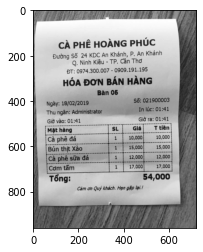

In [66]:
%time gaussianBlur_py = convolutionLayer_py(gray_py, gau_kernel)
plt.imshow(gaussianBlur_py, cmap='gray')
plt.show()

* So sánh kết quả và thời gian thực thi của ba cách

| Thời gian (ms) | Cách tiếp cận |
|:---:|:---|
||openCV|
|| Scipy + Numpy|
|| Python loop|
|| Python loop cached (@jit)|

In [67]:
print("openCV vs Numpy: ", np.abs(gaussianBlur_cv - gaussianBlur_np).mean())
print("openCV vs Python (@jit): ", np.abs(gaussianBlur_cv - gaussianBlur_py).mean())
print("Python (@jit) vs Numpy: ", np.abs(gaussianBlur_py - gaussianBlur_np).mean())

openCV vs Numpy:  34.3620770260301
openCV vs Python (@jit):  34.3620770260301
Python (@jit) vs Numpy:  0.0


#### **Tính Gradient và hướng Gradient**

In [68]:
sobel_x_kernel, sobel_y_kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], np.float32), np.array([[1,2,1],[0,0,0],[-1,-2,-1]], np.float32)

##### Sử dụng hàm của openCV

In [69]:
def edgeGradient_cv(img, is_L2_grad = True):
    sobel_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize = 3)
    sobel_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize = 3)
    edge_sobel = np.hypot(sobel_x, sobel_y) if is_L2_grad else np.abs(sobel_x) + np.abs(sobel_y)
    
    #convert radian value to degree
    angle = np.arctan2(sobel_y, sobel_x) * 180 / np.pi
    angle[angle<0] += 180
        
    return edge_sobel, angle

CPU times: user 64 ms, sys: 6.06 ms, total: 70.1 ms
Wall time: 74.7 ms


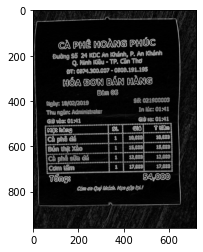

In [70]:
%time edge_sobel_cv, angle_cv = edgeGradient_cv(gaussianBlur_cv)
plt.imshow(edge_sobel_cv, cmap='gray')
plt.show()

##### Sử dụng hàm của numpy

In [71]:
def edgeGradient_np(img, is_L2_grad = True):
    sobel_x = convolutionLayer_np(img,sobel_x_kernel)
    sobel_y = convolutionLayer_np(img,sobel_y_kernel)
    edge_sobel = np.hypot(sobel_x, sobel_y) if is_L2_grad else np.abs(sobel_x) + np.abs(sobel_y)
    
    #convert radian value to degree
    angle = np.arctan2(sobel_y, sobel_x) * 180 / np.pi
    angle[angle<0] += 180
        
    return edge_sobel, angle

CPU times: user 78.6 ms, sys: 2.93 ms, total: 81.6 ms
Wall time: 86.3 ms


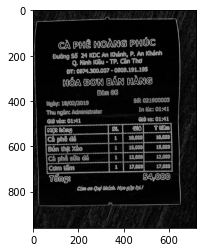

In [72]:
%time edge_sobel_np, angle_np = edgeGradient_np(gaussianBlur_np)
plt.imshow(edge_sobel_np, cmap='gray')
plt.show()

##### Sử dụng @jit cho python thuần

In [73]:
@jit(cache=True)
def matrixElementWise(mat1, mat2 = None, op='*', is_scalar = False):
    out_mat = np.zeros(mat1.shape)
    if is_scalar:
        if op == '+':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] + mat2        
        else:
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] * mat2
    else:
        if op == '+':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] + mat2[i,j]
        elif op == 'sqrt':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] ** 0.5
        elif op == 'abs':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = abs(mat1[i,j])
        elif op == 'arctan2':
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = math.atan2(mat1[i,j], mat2[i,j])
        else:
            for i in range(mat1.shape[0]):
                for j in range(mat1.shape[1]):
                    out_mat[i,j] = mat1[i,j] * mat2[i,j]
    
    return out_mat

In [74]:
@jit(cache=True)
def edgeGradient_py(img, is_L2_grad = True):
    sobel_x = convolutionLayer_py(img,sobel_x_kernel)
    sobel_y = convolutionLayer_py(img,sobel_y_kernel)
    
    edge_sobel = matrixElementWise(
        matrixElementWise(
            matrixElementWise(sobel_x,sobel_x), 
            matrixElementWise(sobel_y,sobel_y), 
            op='+'),
        op='sqrt') if is_L2_grad else matrixElementWise(
        matrixElementWise(
            sobel_x, op='abs'
        ), matrixElementWise(
            sobel_y, op='abs'), 
        op='+')
    
    #convert radian value to degree
    angle = matrixElementWise(
        matrixElementWise(
            sobel_y, 
            sobel_x, 
            op='arctan2'),
        (180 / np.pi),
        is_scalar=True)
    
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            if angle[r,c] < 0:
                angle[r,c] += 180
                    
    return edge_sobel, angle

In [75]:
%time edge_sobel_py, angle_py = edgeGradient_py(gaussianBlur_py)

CPU times: user 10.1 s, sys: 34.1 ms, total: 10.2 s
Wall time: 10.2 s


CPU times: user 95.8 ms, sys: 0 ns, total: 95.8 ms
Wall time: 98.2 ms


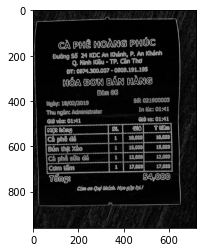

In [76]:
%time edge_sobel_py, angle_py = edgeGradient_py(gaussianBlur_py)
plt.imshow(edge_sobel_py, cmap='gray')
plt.show()

* So sánh kết quả và thời gian thực thi của ba cách

| Thời gian (ms) | Cách tiếp cận |
|:---:|:---|
||openCV|
|| Scipy + Numpy|
|| Python loop|
|| Python loop cached (@jit)|

In [77]:
print('Edge sobel:')
print("openCV vs Numpy: ", np.abs(edge_sobel_cv - edge_sobel_np).mean())
print("openCV vs Python (@jit): ", np.abs(edge_sobel_cv - edge_sobel_py).mean())
print("Python (@jit) vs Numpy: ", np.abs(edge_sobel_py - edge_sobel_np).mean())

Edge sobel:
openCV vs Numpy:  11.021307121302064
openCV vs Python (@jit):  11.021307121302065
Python (@jit) vs Numpy:  8.943962890426025e-16


#### **Non-Maximum Suppression**

##### Sử dụng @jit cho python thuần

In [78]:
@jit(cache=True)
def nonMaxSuppression(img, angle):
    Z = np.zeros(img.shape, np.int32)

    for r in range(1, img.shape[0]-1):
        for c in range(1, img.shape[1]-1):
            q, t = 255, 255
            
            if 0 <= angle[r,c] < 22.5 or 180 >= angle[r,c] >= 157.5:
                q, t = img[r, c+1], img[r, c-1]
            elif 67.5 > angle[r,c] >= 22.5:
                q, t = img[r+1, c-1], img[r-1, c+1]
            elif 112.5 > angle[r,c] >= 67.5:
                q, t = img[r+1, c], img[r-1, c]
            elif 157.5 > angle[r,c] >= 112.5:
                q, t = img[r-1, c-1], img[r+1, c+1]
            
            if img[r,c] >=q and img[r,c] >=t:
                Z[r,c] = img[r,c]
            else:
                Z[r,c] = 0
    return Z

In [79]:
%time non_max_sup_py = nonMaxSuppression(edge_sobel_py, angle_py)

CPU times: user 513 ms, sys: 2.84 ms, total: 515 ms
Wall time: 515 ms


In [80]:
%time non_max_sup_py = nonMaxSuppression(edge_sobel_py, angle_py)

CPU times: user 4.18 ms, sys: 4 µs, total: 4.18 ms
Wall time: 4.11 ms


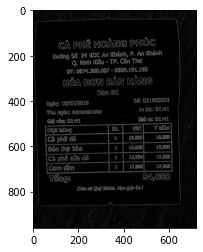

In [81]:
plt.imshow(non_max_sup_py, cmap='gray')
plt.show()

#### **Lọc ngưỡng**

##### Sử dụng @jit cho python thuần

In [82]:
@jit(cache=True)
def hysteresisThreshold(img, min_thres, max_thres):

    canny_mask = np.zeros(img.shape, np.int32)
    max_val = img.max() * max_thres
    min_val = max_val * min_thres
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y,x] > max_val:
                canny_mask[y,x] = 255
            elif img[y,x] > min_val:
                is_edge = False
                for i in range(max(0, y-1), min(img.shape[0], y+2)):
                    for j in range(max(0, x-1), min(img.shape[1], x+2)):
                        if img[i,j] > max_val:
                            is_edge = True
                            canny_mask[y,x] = 255
                            break
                    if is_edge:
                        break
    return canny_mask

In [83]:
%time canny_edge_py = hysteresisThreshold(non_max_sup_py, 0.05, 0.15)

CPU times: user 415 ms, sys: 5.83 ms, total: 420 ms
Wall time: 429 ms


In [84]:
%time canny_edge_py = hysteresisThreshold(non_max_sup_py, 0.05, 0.15)

CPU times: user 8.16 ms, sys: 2 µs, total: 8.16 ms
Wall time: 9.01 ms


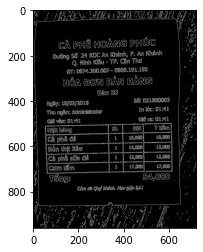

In [85]:
plt.imshow(canny_edge_py, cmap='gray')
plt.show()

* So sánh kết quả và thời gian thực thi của ba cách

| Thời gian (ms) | Cách tiếp cận |
|:---:|:---|
||openCV|
|| Scipy + Numpy|
|| Python loop|
|| Python loop cached (@jit)|

In [86]:
print('Canny:')
print("openCV vs Python (@jit): ", np.abs(canny_edge_cv - canny_edge_py).mean())

Canny:
openCV vs Python (@jit):  5.107747395833333


###  Lấy viền của đối tượng dựa trên các cạnh đã xác định

#### Dùng hàm của OpenCV

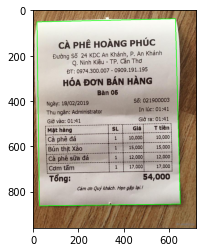

CPU times: user 258 ms, sys: 2.91 ms, total: 261 ms
Wall time: 272 ms


In [87]:
%%time
cnts = cv2.findContours(canny_edge_cv.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
output = img.copy()
for c in cnts:
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)

	if len(approx) == 4:
		screenCnt = approx
		break

cv2.drawContours(output, [screenCnt], -1, (0, 255, 0), 2)
plt.imshow(output)
plt.show()


### Đưa ảnh tài liệu về đối diện màn hình

#### Sử dụng hàm của OpenCV

In [88]:
def four_point_transform(image, pts):

	rect = order_points(pts)
	(tl, tr, br, bl) = rect

	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	return warped

In [89]:
def order_points(pts):
	rect = np.zeros((4, 2), dtype = "float32")

	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	return rect

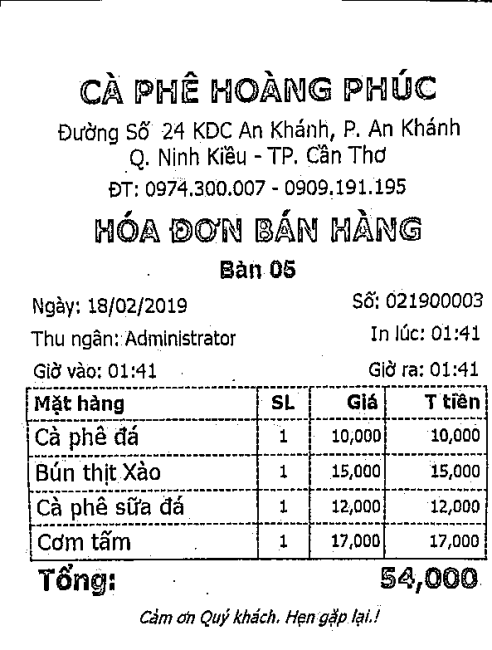

In [90]:
ratio = img.shape[0] / 1000
warped = four_point_transform(img, screenCnt.reshape(4, 2) * ratio)

warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255

cv2_imshow(imutils.resize(warped, height = 650))

### Điều chỉnh độ tương phản, độ sáng của bức ảnh

#### Sử dụng hàm của OpenCV

Processing time: 0.0022535324096679688 s


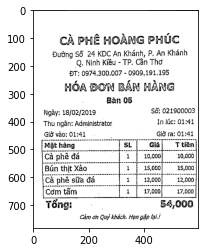

In [94]:
img = cv2.cvtColor(warped, cv2.COLOR_GRAY2BGR)
start = time.time()
new_image = cv2.convertScaleAbs(img, 1.5, 3)
end = time.time()

print(f'Processing time: {end - start} s')


plt.imshow(new_image, cmap='gray')
plt.show()

#### Sử dụng hàm của Numpy

Processing time: 27.820377349853516 s


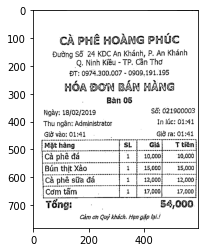

In [97]:
new_image = np.zeros(img.shape, img.dtype)
alpha = 1.5 # Simple contrast control
beta = 3    # Simple brightness control

start = time.time()
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        for c in range(img.shape[2]):
            new_image[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)
end = time.time()
print(f'Processing time: {end - start} s')

plt.imshow(new_image, cmap='gray')
plt.show()

#### Sử dụng @jit

Processing time: 28.796411991119385 s


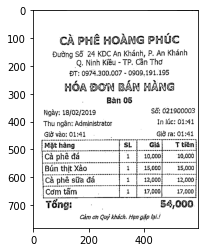

In [98]:
@jit(cache = True)
def adjustBandC(image,alpha,beta):

  new_image = np.zeros(image.shape, image.dtype)
  
  for y in range(image.shape[0]):
      for x in range(image.shape[1]):
          for c in range(image.shape[2]):
              new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)

alpha = 1.5
beta = 3

start = time.time()
adjustBandC(img,alpha,beta)
end = time.time()

print(f'Processing time: {end - start} s')

plt.imshow(new_image, cmap='gray')
plt.show()